# Pluggable TTA Implementation using light-weight sparse autoencoder

## Import Libraries

In [1]:
%pip install ultralytics torchinfo

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
from os import path

import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset

from torchvision import datasets, utils, transforms
from torchinfo import summary
from ultralytics import YOLO

import numpy as np
import pandas as pd

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import pygwalker as pyg
import wandb

datasets.utils.tqdm = tqdm

In [3]:
# WandB Initialization
wandb.init(project="plugin-TTA-ideaA")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: brew (brew-research). Use `wandb login --relogin` to force relogin


### Check GPU Availability

In [4]:
!nvidia-smi

Wed Feb 12 17:50:14 2025       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.29.05    Driver Version: 495.29.05    CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  On   | 00000000:04:00.0 Off |                    0 |
| N/A   41C    P0    34W / 250W |   7320MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-PCIE...  On   | 00000000:06:00.0 Off |                    0 |
| N/A   

In [5]:
# Set CUDA Device Number 0~7
DEVICE_NUM = 4
ADDITIONAL_GPU = 1

if torch.cuda.is_available():
    if ADDITIONAL_GPU:
        torch.cuda.set_device(DEVICE_NUM)
        device = torch.device("cuda")
    else:
        device = torch.device(f"cuda:{DEVICE_NUM}")
else:
    device = torch.device("cpu")
    DEVICE_NUM = -1

print(f"INFO: Using device - {device}" + (f":{DEVICE_NUM}" if ADDITIONAL_GPU else ""))

INFO: Using device - cuda:4


## Load Dataset

### GOT-10k Dataset for Next-frame Prediction Task (Default Pretraining Process)
http://got-10k.aitestunion.com/downloads

#### Data File Structure
The downloaded and extracted full dataset should follow the file structure:
```
    |-- GOT-10k/
        |-- train/
        |  |-- GOT-10k_Train_000001/
        |  |   ......
        |  |-- GOT-10k_Train_009335/
        |  |-- list.txt
        |-- val/
        |  |-- GOT-10k_Val_000001/
        |  |   ......
        |  |-- GOT-10k_Val_000180/
        |  |-- list.txt
        |-- test/
        |  |-- GOT-10k_Test_000001/
        |  |   ......
        |  |-- GOT-10k_Test_000180/
        |  |-- list.txt
```

#### Annotation Description
Each sequence folder contains 4 annotation files and 1 meta file. A brief description of these files follows (let N denotes sequence length):

* groundtruth.txt -- An N×4 matrix with each line representing object location [xmin, ymin, width, height] in one frame.
* cover.label -- An N×1 array representing object visible ratios, with levels ranging from 0~8.
* absense.label -- An binary N×1 array indicating whether an object is absent or present in each frame.
* cut_by_image.label -- An binary N×1 array indicating whether an object is cut by image in each frame.
* meta_info.ini -- Meta information about the sequence, including object and motion classes, video URL and more.
* Values 0~8 in file cover.label correspond to ranges of object visible ratios: 0%, (0%, 15%], (15%~30%], (30%, 45%], (45%, 60%], (60%, 75%], (75%, 90%], (90%, 100%) and 100% respectively.

In [6]:

from typing import Callable, Optional


class GOT10kDataset(datasets.ImageFolder):
    download_method = datasets.utils.download_and_extract_archive
    download_url = "https://drive.google.com/file/d/1b75MBq7MbDQUc682IoECIekoRim_Ydk1/view?usp=sharing"
    file_name = "full_data.zip"

    def __init__(self, root: str, force_download: bool = True, train: bool = True, valid: bool = False, transform: Optional[Callable] = None, target_transform: Optional[Callable] = None):
        self.download(root, force=force_download)

        if train:
            root = path.join(root, "val") if valid else path.join(root, "train")
        else:
            root = path.join(root, "test")

        super().__init__(root=root, transform=transform, target_transform=target_transform)

    @classmethod
    def download(cls, root: str, force: bool = False):
        if force or not path.isfile(path.join(root, cls.file_name)):
            cls.download_method(cls.download_url, download_root=root, extract_root=root, filename=cls.file_name)
            print("INFO: Dataset archive downloaded and extracted.")
        else:
            print("INFO: Dataset archive found in the root directory. Skipping download.")

    @property
    def df(self) -> pd.DataFrame:
        return pd.DataFrame(dict(path=[d[0] for d in self.samples], label=[self.classes[lb] for lb in self.targets]))

In [7]:
# Define image size for resizing
IMG_SIZE = 224

# Define image normalization parameters
IMG_NORM = {
    'mean': [0.485, 0.456, 0.406],
    'std': [0.229, 0.224, 0.225]
}

# Create transforms
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Adjust brightness/contrast
    transforms.ToTensor(),
    transforms.Normalize(**IMG_NORM)
])

test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(), 
    transforms.Normalize(**IMG_NORM)
])

In [8]:
DATA_ROOT = path.join(".", "data", "GOT10k")

train_dataset = GOT10kDataset(root=DATA_ROOT, force_download=False, train=True, transform=train_transform)
valid_dataset = GOT10kDataset(root=DATA_ROOT, force_download=False, valid=True, transform=train_transform)
test_dataset = GOT10kDataset(root=DATA_ROOT, force_download=False, train=False, transform=test_transform)

print(f"INFO: Dataset loaded successfully. Number of samples - Train({len(train_dataset)}), Valid({len(valid_dataset)}), Test({len(test_dataset)})")

INFO: Dataset archive found in the root directory. Skipping download.
INFO: Dataset archive found in the root directory. Skipping download.
INFO: Dataset archive found in the root directory. Skipping download.
INFO: Dataset loaded successfully. Number of samples - Train(1403359), Valid(21007), Test(22834)


In [9]:
# Train Dataset Distribution
pyg.walk(train_dataset.df)

Box(children=(HTML(value='\n<div id="ifr-pyg-00062df5934007555YF7AnCHQgJu1caO" style="height: auto">\n    <hea…

In [10]:
import random
from PIL import Image
from collections import defaultdict


class PairedGOT10kDataset(Dataset):
    def __init__(self, base_dataset: GOT10kDataset):
        super().__init__()
        self.base_dataset = base_dataset
        self.pairs = self._create_pairs()
        self.use_teacher_forcing = False
        
    def _create_pairs(self):
        sequences = defaultdict(list)
        for idx, (img_path, _) in enumerate(self.base_dataset.samples):
            seq_name = path.dirname(img_path)
            sequences[seq_name].append((idx, img_path))
            
        for seq_name in sequences:
            sequences[seq_name].sort(key=lambda x: x[1])

        pairs = []
        for seq_name, frames in sequences.items():
            gt_path = path.join(seq_name, 'groundtruth.txt')
            if path.exists(gt_path):
                groundtruth = np.loadtxt(gt_path, delimiter=',')
                
                # Get original image dimensions for normalization
                img_path = frames[0][1]  # Use first frame to get dimensions
                with Image.open(img_path) as img:
                    orig_w, orig_h = img.size
                    
                # Normalize groundtruth coordinates
                for i in range(len(frames) - 1):
                    # Original format: [x_min, y_min, width, height]
                    # Convert to normalized coordinates
                    gt_curr = groundtruth[i + 1].copy()
                    gt_prev = groundtruth[i].copy()
                    
                    # Normalize coordinates
                    gt_prev[0] /= orig_w  # x_min
                    gt_prev[1] /= orig_h  # y_min
                    gt_prev[2] /= orig_w  # width
                    gt_prev[3] /= orig_h  # height
                    
                    gt_curr[0] /= orig_w  # x_min
                    gt_curr[1] /= orig_h  # y_min
                    gt_curr[2] /= orig_w  # width
                    gt_curr[3] /= orig_h  # height
                    
                    pairs.append({
                        'prev_idx': frames[i][0],
                        'curr_idx': frames[i + 1][0],
                        'prev_gt': gt_prev,
                        'curr_gt': gt_curr
                    })
        
        return pairs
    
    def __len__(self):
        return len(self.pairs)
    
    def __getitem__(self, idx):
        pair = self.pairs[idx]
        
        prev_img = None
        if not self.use_teacher_forcing:
            prev_img, _ = self.base_dataset[pair['prev_idx']]
        curr_img, _ = self.base_dataset[pair['curr_idx']]
        
        prev_gt = torch.FloatTensor(pair['prev_gt'])
        curr_gt = torch.FloatTensor(pair['curr_gt'])
        
        if prev_img is None:
            return curr_img, curr_gt, curr_gt
        return prev_img, curr_img, prev_gt, curr_gt

    @classmethod
    def create_train_val_split(cls, base_dataset: GOT10kDataset, train_ratio=0.9, seed=42):
        # Get unique sequence paths efficiently using dict.fromkeys()
        sequences = list(dict.fromkeys(path.dirname(img_path) for img_path, _ in base_dataset.samples))
        
        # Set random seed and shuffle sequences
        random.seed(seed)
        random.shuffle(sequences)
        split_idx = int(len(sequences) * train_ratio)
        
        # Create sequence sets for faster lookups
        train_sequences = set(sequences[:split_idx])
        val_sequences = set(sequences[split_idx:])
        
        # Create train and val datasets
        train_dataset = GOT10kDataset(root=path.dirname(base_dataset.root), force_download=False, train=True, transform=base_dataset.transform)
        val_dataset = GOT10kDataset(root=path.dirname(base_dataset.root), force_download=False, train=True, transform=base_dataset.transform)
        
        # Split samples and targets in one pass
        train_samples = []
        train_targets = []
        val_samples = []
        val_targets = []
        
        for i, (sample, target) in enumerate(zip(base_dataset.samples, base_dataset.targets)):
            seq_dir = path.dirname(sample[0])
            if seq_dir in train_sequences:
                train_samples.append(sample)
                train_targets.append(target)
            else:
                val_samples.append(sample)
                val_targets.append(target)
        
        train_dataset.samples = train_samples
        train_dataset.targets = train_targets
        val_dataset.samples = val_samples
        val_dataset.targets = val_targets
        
        return cls(train_dataset), cls(val_dataset)

In [11]:
# Create paired datasets with lazy loading
train_pairset, valid_pairset = PairedGOT10kDataset.create_train_val_split(train_dataset)
test_pairset = PairedGOT10kDataset(base_dataset=valid_dataset)

print(f"INFO: PairedDataset initialized. Total sequences - Train({len(train_pairset)}), Valid({len(valid_pairset)}), Test({len(test_pairset)})")

INFO: Dataset archive found in the root directory. Skipping download.
INFO: Dataset archive found in the root directory. Skipping download.
INFO: PairedDataset initialized. Total sequences - Train(1253072), Valid(140952), Test(20827)


In [12]:
train_pairset[0]

(tensor([[[-0.9534, -1.2959, -1.4500,  ..., -1.1075, -1.2274, -1.2103],
          [-0.3369, -0.6623, -1.2788,  ..., -1.0048, -0.9020, -0.9534],
          [-1.0048, -0.8678, -1.1932,  ..., -1.0562, -0.4739, -1.2103],
          ...,
          [-1.3644, -1.5357, -1.6384,  ..., -1.1418, -1.0048, -1.0048],
          [-1.3987, -1.6213, -1.6042,  ..., -1.0390, -0.9877, -1.0048],
          [-1.2959, -1.6213, -1.6384,  ..., -1.0904, -1.0048, -0.9705]],
 
         [[-0.6527, -1.0553, -1.2479,  ..., -0.8803, -1.0203, -1.0028],
          [-0.0399, -0.4076, -1.0903,  ..., -0.7927, -0.6702, -0.7227],
          [-0.7227, -0.5826, -1.0203,  ..., -0.8452, -0.2325, -1.0028],
          ...,
          [-1.2129, -1.3880, -1.5105,  ..., -0.8803, -0.7577, -0.7752],
          [-1.1954, -1.4230, -1.4580,  ..., -0.6702, -0.6877, -0.7227],
          [-1.0553, -1.3880, -1.4755,  ..., -0.6877, -0.6877, -0.6527]],
 
         [[-0.9156, -1.2641, -1.3861,  ..., -1.3339, -1.4907, -1.4384],
          [-0.3055, -0.6541,

In [13]:
def visualize_frame_pair(pairset, idx=None, figsize=(15, 7)):
    """
    Visualize a pair of consecutive frames with their bounding boxes.
    
    Args:
        pairset: PairedGOT10kDataset instance
        idx: Index of the pair to visualize. If None, picks a random index
        figsize: Size of the figure as (width, height)
    """
    # Get random index if not provided
    if idx is None:
        idx = np.random.randint(len(pairset))
    
    # Get frame pair
    prev_img, curr_img, prev_gt, curr_gt = pairset[idx]
    
    def draw_bbox(bbox, color='red'):
        """Helper function to draw bounding box"""
        plt.plot([bbox[0], bbox[0]+bbox[2]], [bbox[1], bbox[1]], color=color, linewidth=2)
        plt.plot([bbox[0], bbox[0]], [bbox[1], bbox[1]+bbox[3]], color=color, linewidth=2)
        plt.plot([bbox[0]+bbox[2], bbox[0]+bbox[2]], [bbox[1], bbox[1]+bbox[3]], color=color, linewidth=2)
        plt.plot([bbox[0], bbox[0]+bbox[2]], [bbox[1]+bbox[3], bbox[1]+bbox[3]], color=color, linewidth=2)

    # Create figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
    # Plot previous frame
    plt.subplot(1, 2, 1)
    plt.imshow(prev_img)
    draw_bbox(prev_gt.numpy())
    plt.title('Previous Frame')
    
    # Plot current frame
    plt.subplot(1, 2, 2)
    plt.imshow(curr_img)
    draw_bbox(curr_gt.numpy())
    plt.title('Current Frame')
    
    plt.tight_layout()
    plt.show()
    
    return idx

In [14]:
def visualize_normalized_frame_pair(pairset, idx=None, imgsize=(IMG_SIZE, IMG_SIZE), figsize=(7, 5)):
    """
    Visualize a pair of consecutive frames with their bounding boxes.
    
    Args:
        pairset: PairedGOT10kDataset instance
        idx: Index of the pair to visualize. If None, picks a random index
        imgsize: Size of the image as (width, height)
        figsize: Size of the figure as (width, height)
    """
    # Get random index if not provided
    if idx is None:
        idx = np.random.randint(len(pairset))
    
    # Get frame pair
    prev_img, curr_img, prev_gt, curr_gt = pairset[idx]
    
    # Convert tensors to numpy arrays and denormalize
    def denormalize(img_tensor):
        # Move channels to last dimension
        img = img_tensor.permute(1, 2, 0).numpy()
        # Denormalize
        img = img * np.array(IMG_NORM['std']) + np.array(IMG_NORM['mean'])
        # Clip values to valid range
        img = np.clip(img, 0, 1)
        return img
    
    prev_img = denormalize(prev_img)
    curr_img = denormalize(curr_img)
    
    def draw_bbox(ax, bbox, color='red'):
        """Helper function to draw bounding box"""
        x, y, w, h = bbox.numpy()
        x *= imgsize[0]
        y *= imgsize[1]
        w *= imgsize[0]
        h *= imgsize[1]
        ax.plot([x, x+w], [y, y], color=color, linewidth=2)
        ax.plot([x, x], [y, y+h], color=color, linewidth=2)
        ax.plot([x+w, x+w], [y, y+h], color=color, linewidth=2)
        ax.plot([x, x+w], [y+h, y+h], color=color, linewidth=2)

    # Create figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
    # Plot previous frame
    ax1.imshow(prev_img)
    draw_bbox(ax1, prev_gt)
    ax1.set_title('Previous Frame')
    ax1.axis('off')
    
    # Plot current frame
    ax2.imshow(curr_img)
    draw_bbox(ax2, curr_gt)
    ax2.set_title('Current Frame')
    ax2.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return idx

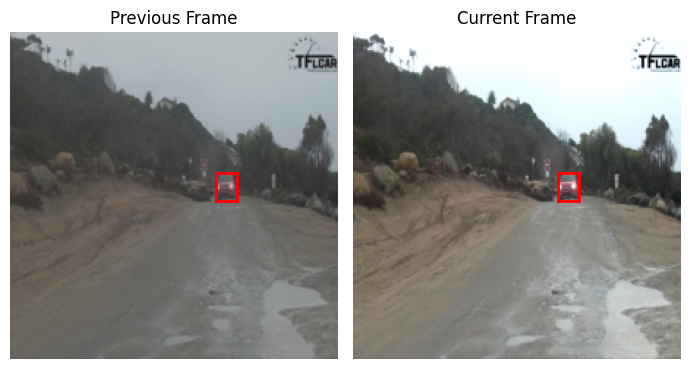

Visualized pair index: 18948


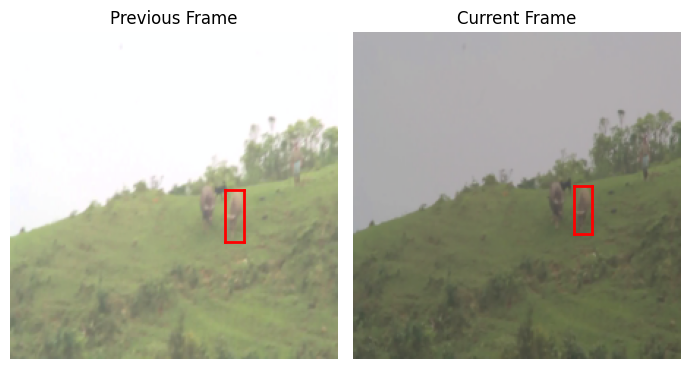

Visualized pair index: 277928


In [15]:
for _ in range(2):
    selected_idx = visualize_normalized_frame_pair(train_pairset)
    print(f"Visualized pair index: {selected_idx}")

## DataLoader

In [16]:
# Set Batch Size
BATCH_SIZE = 512, 512, 512

In [17]:
# Use Teacher Forcing
train_pairset.use_teacher_forcing = True
train_pairset.use_teacher_forcing = True

In [18]:
MULTI_PROCESSING = True  # Set False if DataLoader is causing issues

from platform import system
if MULTI_PROCESSING and system() != "Windows":  # Multiprocess data loading is not supported on Windows
    import multiprocessing
    cpu_cores = multiprocessing.cpu_count()
    print(f"INFO: Number of CPU cores - {cpu_cores}")
else:
    cpu_cores = 0
    print("INFO: Using DataLoader without multi-processing.")

train_loader = DataLoader(train_pairset, batch_size=BATCH_SIZE[0], shuffle=True, num_workers=cpu_cores)
valid_loader = DataLoader(valid_pairset, batch_size=BATCH_SIZE[1], shuffle=False, num_workers=cpu_cores)
test_loader = DataLoader(test_pairset, batch_size=BATCH_SIZE[2], shuffle=False, num_workers=cpu_cores)

INFO: Number of CPU cores - 48


## Define Model
### APT: Adaptive Plugin for TTA (Test-time Adaptation)

In [19]:
yolo_pretrained = YOLO("./pretrained/yolo11m.pt")
yolo_pretrained.cpu()

for param in yolo_pretrained.parameters():
    param.requires_grad = False  # Freeze YOLO

yolo_pretrained.model

DetectionModel(
  (model): Sequential(
    (0): Conv(
      (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (1): Conv(
      (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (2): C3k2(
      (cv1): Conv(
        (conv): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (cv2): Conv(
        (conv): Conv2d(192, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(256, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
   

In [20]:
def print_model_structure(model):
    for i, layer in enumerate(model.model):
        print(f"Layer {i}: {layer.__class__.__name__}")

In [21]:
print_model_structure(yolo_pretrained.model)

Layer 0: Conv
Layer 1: Conv
Layer 2: C3k2
Layer 3: Conv
Layer 4: C3k2
Layer 5: Conv
Layer 6: C3k2
Layer 7: Conv
Layer 8: C3k2
Layer 9: SPPF
Layer 10: C2PSA
Layer 11: Upsample
Layer 12: Concat
Layer 13: C3k2
Layer 14: Upsample
Layer 15: Concat
Layer 16: C3k2
Layer 17: Conv
Layer 18: Concat
Layer 19: C3k2
Layer 20: Conv
Layer 21: Concat
Layer 22: C3k2
Layer 23: Detect


In [22]:
# Split YOLO into encoder/decoder parts
yolo_encoder = yolo_pretrained.model.model[:9]  # Backbone
yolo_decoder = yolo_pretrained.model.model[9:]  # Neck + Head layers

In [23]:
summary(yolo_encoder, input_size=(1, 3, IMG_SIZE, IMG_SIZE))

Layer (type:depth-idx)                                  Output Shape              Param #
Sequential                                              [1, 512, 7, 7]            --
├─Conv: 1-1                                             [1, 64, 112, 112]         --
│    └─Conv2d: 2-1                                      [1, 64, 112, 112]         (1,728)
│    └─BatchNorm2d: 2-2                                 [1, 64, 112, 112]         (128)
├─C3k2: 1-64                                            --                        (recursive)
│    └─ModuleList: 2-73                                 --                        (recursive)
│    │    └─C3k: 3-72                                   --                        (recursive)
├─Conv: 1-3                                             [1, 128, 56, 56]          --
│    └─Conv2d: 2-4                                      [1, 128, 56, 56]          (73,728)
│    └─BatchNorm2d: 2-5                                 [1, 128, 56, 56]          (256)
├─C3k2: 1-64    

In [24]:
class FeatureNormalizationLayer(nn.Module):
    def __init__(self, target_dim=256):
        super().__init__()
        self.target_dim = target_dim
        
        # Keep only channel dimension
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        # Linear compression
        self.linear_compress = nn.AdaptiveAvgPool1d(self.target_dim)
        
        # Feature normalization
        self.feature_norm = nn.Sequential(
            nn.LayerNorm(target_dim),
            nn.Dropout(0.1)
        )
        
        
    def forward(self, x):
        # Apply adaptive pooling
        x = self.adaptive_pool(x)
        
        # Squeeze channel dimension
        x = x.squeeze(-1).squeeze(-1)
        
        # Linear compression
        x = self.linear_compress(x)
        
        # Feature normalization
        x = self.feature_norm(x)
        
        return x

In [25]:
class APT(nn.Module):
    """
    Light-weight Sparse Autoencoder for Adaptation
    which learns how to sniff out the frame changes to predict next bounding boxes.
    """
    def __init__(self, feature_dim=256, bbox_dim=4, hidden_dim=32, sparsity_param=0.1):
        super().__init__()
        
        self.feature_dim = feature_dim
        self.bbox_dim = bbox_dim
        self.hidden_dim = hidden_dim
        self.sparsity_param = sparsity_param
        
        # Feature normalization layer for encoder-agnostic adaptation
        self.feature_norm = FeatureNormalizationLayer(target_dim=feature_dim)

        # Lightweight feature sniffer
        self.feature_sniffer = nn.Sequential(
            nn.Linear(feature_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim // 4 * 3)
        )

        # Previous bbox encoder
        self.bbox_encoder = nn.Sequential(
            nn.Linear(bbox_dim, hidden_dim // 4),
            nn.ReLU()
        )

        # Fusion layer
        self.fusion = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )

        # Prediction head
        self.predictor = nn.Sequential(
            nn.Linear(hidden_dim, bbox_dim),
            nn.Sigmoid()  # Normalize bbox coordinates to [0,1]
        )

        # Optional: Sparsity regularization
        self.activation = {}
        
    def forward(self, features, prev_bbox):
        # Normalize encoder features to be encoder-agnostic
        norm_features = self.feature_norm(features)
        
        # Extract relevant features from current frame
        sniffed_features = self.feature_sniffer(norm_features)
        
        # Encode previous bbox information
        bbox_features = self.bbox_encoder(prev_bbox)
        
        # Fuse features
        fused = self.fusion(
            torch.cat([sniffed_features, bbox_features], dim=-1)
        )
        
        # Predict next bbox
        next_bbox = self.predictor(fused)
        
        # Store activation for sparsity regularization if needed
        self.activation['hidden'] = fused
        
        return next_bbox
    
    def get_sparsity_loss(self):
        """Calculate sparsity regularization loss"""
        if 'hidden' not in self.activation:
            return 0
            
        rho_hat = torch.mean(self.activation['hidden'], dim=0)
        rho = torch.full_like(rho_hat, self.sparsity_param)
        
        # KL divergence for sparsity regularization
        sparsity_loss = torch.sum(
            rho * torch.log(rho/rho_hat) + 
            (1-rho) * torch.log((1-rho)/(1-rho_hat))
        )
        
        return sparsity_loss

In [26]:
class TestTimeAdaptiveYOLO(nn.Module):
    def __init__(
        self, encoder: nn.Module, decoder: nn.Module,
        feature_dim=256, bbox_dim=4, hidden_dim=32, sparsity_param=0.1
    ):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.apt = APT(
            feature_dim=feature_dim, bbox_dim=bbox_dim,
            hidden_dim=hidden_dim, sparsity_param=sparsity_param
        )
        
    def forward(self, current_frame, prev_bbox, use_teacher_forcing=False):
        # Extract features using YOLO encoder
        features = self.encoder(current_frame)
        
        # Adapt using APT
        pred_bbox = self.apt(features, prev_bbox)
        
        if use_teacher_forcing:
            output = None
        else:
            # Use YOLO decoder for final prediction
            output = self.decoder(features)
        
        return output, pred_bbox, self.apt.get_sparsity_loss()

In [27]:
# Initialize Model
model = TestTimeAdaptiveYOLO(
    encoder=yolo_encoder, decoder=yolo_decoder,
    feature_dim=256, bbox_dim=4, hidden_dim=32, sparsity_param=0.1
)

if ADDITIONAL_GPU:
    model = nn.DataParallel(model, device_ids=list(range(DEVICE_NUM, DEVICE_NUM+ADDITIONAL_GPU+1)))
model.to(device)

DataParallel(
  (module): TestTimeAdaptiveYOLO(
    (encoder): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C3k2(
        (cv1): Conv(
          (conv): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(192, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(256, eps=0.001, momentum=0.03, af

## Training

In [28]:
from IPython.display import display
import ipywidgets as widgets

# Interactive Loss Plot Update
def create_plot():
    train_losses, valid_losses = [], []

    # Enable Interactive Mode
    plt.ion()

    # Loss Plot Setting
    fig, ax = plt.subplots(figsize=(6, 2))
    train_line, = ax.plot(train_losses, label="Train Loss", color="purple")
    valid_line, = ax.plot(valid_losses, label="Valid Loss", color="red")
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Loss")
    ax.set_title("Model Loss Graph")

    # Display Plot
    plot = widgets.Output()
    display(plot)

    def update_plot(train_loss=None, valid_loss=None):
        if train_loss is not None:
            train_losses.append(train_loss)
        if valid_loss is not None:
            valid_losses.append(valid_loss)
        train_line.set_ydata(train_losses)
        train_line.set_xdata(range(len(train_losses)))
        valid_line.set_ydata(valid_losses)
        valid_line.set_xdata(range(len(valid_losses)))
        ax.relim()
        ax.autoscale_view()
        with plot:
            plot.clear_output(wait=True)
            display(fig)

    return update_plot

In [29]:
def avg(lst):
    try:
        return sum(lst) / len(lst)
    except ZeroDivisionError:
        return 0

In [30]:
def calculate_iou(box1, box2):
    """
    box shape: [x1, y1, x2, y2]
    """
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])
    
    # calculate the area of intersection rectangle
    intersection = max(0, x2 - x1) * max(0, y2 - y1)
    
    # calculate the area of both the prediction and ground truth
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    
    union = box1_area + box2_area - intersection
    
    return intersection / union if union > 0 else 0

In [31]:
def calculate_ciou(box1, box2):
     """
     Calculate CIoU (Complete IoU) between two bounding boxes
     box format: [x, y, w, h] (normalized)
     """
     # Convert boxes to [x1, y1, x2, y2] format
     b1_x1, b1_y1 = box1[0], box1[1]
     b1_x2, b1_y2 = box1[0] + box1[2], box1[1] + box1[3]
     b2_x1, b2_y1 = box2[0], box2[1] 
     b2_x2, b2_y2 = box2[0] + box2[2], box2[1] + box2[3]
     
     # Calculate area of boxes
     b1_area = box1[2] * box1[3]
     b2_area = box2[2] * box2[3]
     
     # Calculate intersection area
     inter_x1 = max(b1_x1, b2_x1)
     inter_y1 = max(b1_y1, b2_y1)
     inter_x2 = min(b1_x2, b2_x2)
     inter_y2 = min(b1_y2, b2_y2)
     
     inter_area = max(0, inter_x2 - inter_x1) * max(0, inter_y2 - inter_y1)
     
     # Calculate union area
     union_area = b1_area + b2_area - inter_area
     
     # Calculate IoU
     iou = inter_area / (union_area + 1e-7)  # Add small epsilon to avoid division by zero
     
     # Calculate the center distance
     center_x1 = (b1_x1 + b1_x2) / 2
     center_y1 = (b1_y1 + b1_y2) / 2
     center_x2 = (b2_x1 + b2_x2) / 2
     center_y2 = (b2_y1 + b2_y2) / 2
     
     center_distance = (center_x1 - center_x2) ** 2 + (center_y1 - center_y2) ** 2
     
     # Calculate diagonal distance of smallest enclosing box
     enclosing_x1 = min(b1_x1, b2_x1)
     enclosing_y1 = min(b1_y1, b2_y1)
     enclosing_x2 = max(b1_x2, b2_x2)
     enclosing_y2 = max(b1_y2, b2_y2)
     
     diagonal_distance = (enclosing_x2 - enclosing_x1) ** 2 + (enclosing_y2 - enclosing_y1) ** 2
     
     # Calculate aspect ratio term
     v = 4 / (np.pi ** 2) * (np.arctan(box1[2]/(box1[3] + 1e-7)) - np.arctan(box2[2]/(box2[3] + 1e-7))) ** 2
     
     # Calculate alpha term for CIoU
     alpha = v / (1 - iou + v + 1e-7)
     
     # Calculate CIoU
     ciou = iou - center_distance / (diagonal_distance + 1e-7) - alpha * v
     
     # Clip CIoU to [0,1] range
     return max(0.0, min(1.0, ciou))

### Default Pre-training Process
Using Teacher forcing

In [32]:
# Set Epoch Count & Learning Rate
EPOCHS = 10
LEARNING_RATE = 5e-3, 1e-6
WEIGHT_DECAY = 0.05
MSE_WEIGHT = 0.4
SPARSITY_WEIGHT = 0.01
CIoU_WEIGHT = 1.5

criterion = nn.MSELoss()
wandb.watch(model, criterion, log="all", log_freq=10)
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE[0], weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=LEARNING_RATE[1])

In [ ]:
train_length, valid_length = map(len, (train_loader, valid_loader))
epochs = tqdm(range(EPOCHS), desc="Running Epochs")
with (tqdm(total=train_length, desc="Training") as train_progress,
        tqdm(total=valid_length, desc="Validation") as valid_progress):  # Set up Progress Bars
    update = create_plot()  # Create Loss Plot

    for epoch in epochs:
        train_progress.reset(total=train_length)
        valid_progress.reset(total=valid_length)

        train_loss, train_ciou = 0, 0

        # Training
        model.train()
        for i, (curr_frame, prev_bbox, curr_bbox) in enumerate(train_loader):
            optimizer.zero_grad()

            prev_bbox, curr_bbox = prev_bbox.to(device), curr_bbox.to(device)
            _, pred_bbox, sparsity_loss = model(curr_frame.to(device), prev_bbox, use_teacher_forcing=True)  # Use Teacher Forcing while training

            mse_loss = criterion(pred_bbox, curr_bbox)
            ciou_loss = 1 - avg([calculate_ciou(pred_bbox[j].detach().cpu().numpy(), curr_bbox[j].cpu().numpy()) for j in range(len(pred_bbox))])
            sparsity_loss = torch.mean(sparsity_loss)
            
            (MSE_WEIGHT*mse_loss + SPARSITY_WEIGHT*sparsity_loss + CIoU_WEIGHT*ciou_loss).backward()
            optimizer.step()
            scheduler.step()

            train_loss += mse_loss.item() / train_length
            train_ciou += ciou_loss / train_length

            train_progress.update(1)
            if i != train_length-1: wandb.log({'MSE Loss': mse_loss.item(), 'Sparsity Loss': sparsity_loss, 'CIoU Loss': ciou_loss})
            print(f"\rEpoch [{epoch+1:2}/{EPOCHS}], Step [{i+1:4}/{train_length}], MSE Loss: {mse_loss.item():.6f}, CIoU Loss: {ciou_loss:.6f}", end="")

        print(f"\rEpoch [{epoch+1:2}/{EPOCHS}], Step [{train_length}/{train_length}], MSE Loss: {train_loss:.6f}, CIoU Loss: {train_ciou:.6f}", end="")
        val_loss, val_ciou = 0, 0

        # Validation
        model.eval()
        with torch.no_grad():
            for curr_frame, prev_bbox, curr_bbox in valid_loader:
                prev_bbox, curr_bbox = prev_bbox.to(device), curr_bbox.to(device)
                _, pred_bbox, sparsity_loss = model(curr_frame.to(device), prev_bbox, use_teacher_forcing=True)  # Use Teacher Forcing while training

                val_loss += criterion(pred_bbox, curr_bbox).item() / valid_length
                val_ciou += (1-avg([calculate_ciou(pred_bbox[j].detach().cpu().numpy(), curr_bbox[j].cpu().numpy()) for j in range(len(pred_bbox))])) / valid_length
                valid_progress.update(1)

        update(train_loss=train_loss, valid_loss=val_loss)
        wandb.log({'Train MSE Loss': train_loss, 'Train CIoU Loss': train_ciou, 'Val MSE Loss': val_loss, 'Val CIoU Loss': val_ciou})
        print(f"\rEpoch [{epoch+1:2}/{EPOCHS}], Step [{train_length}/{train_length}], MSE Loss: {train_loss:.6f}, CIoU Loss: {train_ciou:.6f}, Valid MSE Loss: {val_loss:.6f}, Valid CIoU Loss: {val_ciou:.6f}", end="\n" if (epoch+1) % 5 == 0 or (epoch+1) == EPOCHS else "")

Running Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/2448 [00:00<?, ?it/s]

Validation:   0%|          | 0/276 [00:00<?, ?it/s]

Output()

/shared_hdd/brew/anaconda3/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch [ 1/10], Step [1119/2448], MSE Loss: 0.001008, CIoU Loss: 0.434023

In [ ]:
if not path.isdir(path.join(".", "models")):
    os.mkdir(path.join(".", "models"))

# Model Save
save_path = path.join(".", "models", f"apt_model.pt")
torch.save(model.apt.state_dict(), save_path)
torch.save(model.state_dict(), path.join(save_path, f"apt_model.pt"))
print(f"Model saved to {save_path}")

## Test

In [ ]:
# Load Model
model_id = "normal_vit_model"

model.load_state_dict(torch.load(path.join(".", "models", f"{model_id}.pt")))
model.to(device)

In [ ]:
corrects = 0
test_length = len(test_dataset)

model.eval()
with torch.no_grad():
    for inputs, targets in tqdm(test_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        corrects += (preds == targets.data).sum()
        print(f"Model Accuracy: {corrects/test_length:%}", end="\r")

In [ ]:
corrects = 0
test_length = len(test_dataset)

model.eval()
with torch.no_grad():
    for inputs, targets in tqdm(test_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(pixel_values=inputs, labels=targets, use_cache=False)
        _, preds = torch.max(outputs.logits[:, -1, :], 1)
        corrects += (preds == targets.data).sum()
        print(f"Model Accuracy: {corrects/test_length:%}", end="\r")